# Table of Contents

MOI = Morisita's overlap index

The use of the word "child" is being used interchangeably to mean "the anne subcorpus of Manchester" and "the CHI speaker in the anne subcorpus of Manchester". This can be confusing sometimes.

## [Per-session Child-Adult MOI](#basic-morisita)

Unigram, bigram, trigram per-session MOI between child and adult. 

We look at each Manchester subcorpus individually and see how the MOI between the child and adult change over time, and then aggregate these observations.

## [Per-session Child-Adult MOI on common ngrams](#zero-count-ngrams)
The same analysis as above, but ngrams that were not shared between child and adult during a single session are dropped from the MOI of that session.

In computing the MOI for session 4 between Anne and her mother, the only ngrams used will be those produced by *both* Anne and her mother during session 4.

## [Adult-Adult MOI](#adult-adult-moi)

Similar to the above analysis but we simulate adult-adult conversations by pairing up the adults in the Manchester corpus in every possible combination.

"Pretend Anne's mom and Aran's mom were talking to each other for all 34 sessions instead of their children. How does their MOI vary over time?"

## [Child-Child MOI](#child-child-moi)

Same analysis as above but simulating conversation between pairings of children.

## [Child-Child MOI on common ngrams](#child-child-moi-common-within-session)

Same as above but only running MOI on the ngrams common to two children during a session.

In computing the MOI for session 4 between Anne and Aran, the only ngrams used will be those produced by *both* Anne and Aran during session 4.

## Per-Child plots
A single plot for each Manchester child's per-session child-adult MOI.
- [Per-Child Unigrams Plots](#per-child-unigram)
- [Per-Child Bigram Plots](#per-child-bigram)
- [Per-Child Trigram Plots](#per-child-trigram)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dataset import get_manchester

def morisita(a, b, drop_zeros=False, randomize=False):
    if randomize:
        b.index = np.random.permutation(b.index)
    if drop_zeros:
        df = pd.DataFrame({'a': a, 'b': b}).dropna(how='any')
        a, b = df.a, df.b
    else:
        a, b = a.align(b, fill_value=0)
    a = a / a.sum()
    b = b / b.sum()
    numer = np.dot(a, b)
    denom = np.square(a).sum() + np.square(b).sum()
    return 2 * numer / denom

def morisita_child_adult(df, drop_zeros=False):
    child = df[df.speaker.eq('CHI')].ngram.value_counts()
    adult = df[df.speaker.eq('MOT')].ngram.value_counts()
    return morisita(child, adult, drop_zeros=drop_zeros)

def morisita_adult_adult(df, corpus1, corpus2):
    adult1 = df[df.speaker.eq('MOT') & df.corpus.eq(corpus1)].ngram.value_counts()
    adult2 = df[df.speaker.eq('MOT') & df.corpus.eq(corpus2)].ngram.value_counts()
    return morisita(adult1, adult2)

def per_session_plot(title):
    plt.grid()
    plt.xticks(np.arange(1,35))
    plt.title(title)
    plt.legend()
    plt.xlabel('Session Number')
    plt.ylabel("Morisita's Overlap Index")
    plt.show()

# Quick Test 

Testing example from "Testing for Significance of Morisita's, Horn's and Related Measures of Overlap"

The morisita calculation for X and Y should be 0.83

In [30]:
x = pd.Series([.2, .3, .5])
y = pd.Series([.1, .6, .3])
morisita(x, y)

0.83333333333333326

# Load Dataset

In [5]:
unigrams, bigrams, trigrams = get_manchester("/home/paul/corpora/Manchester/**/*", 
                                            cached=True, 
                                            gram_sizes=[1, 2, 3])

<a id='basic-morisita'></a>
# Basic Child-Adult Morisita comparison

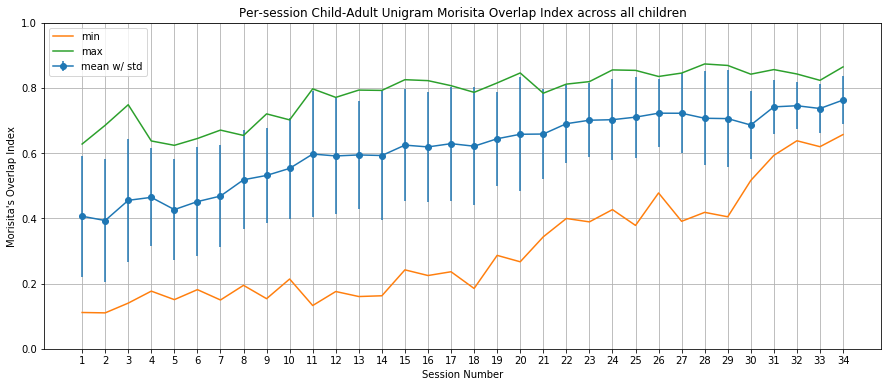

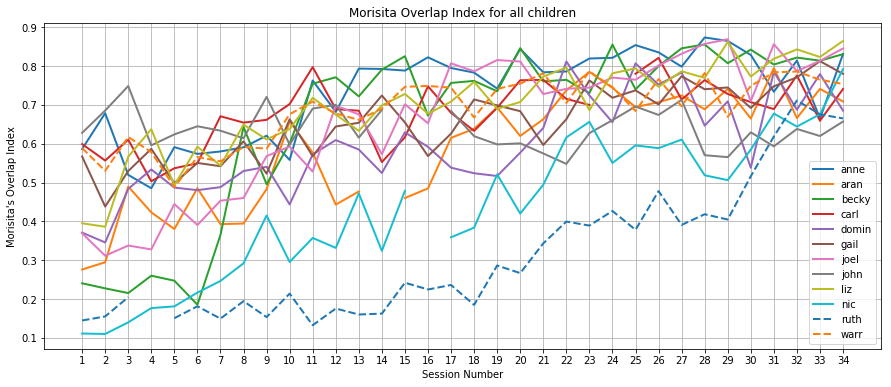

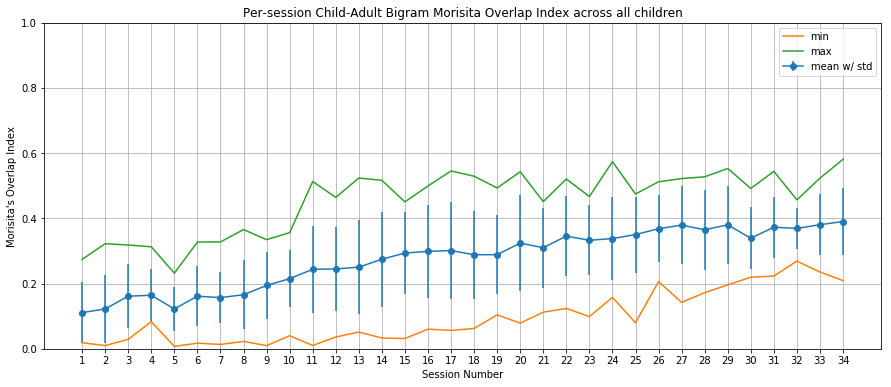

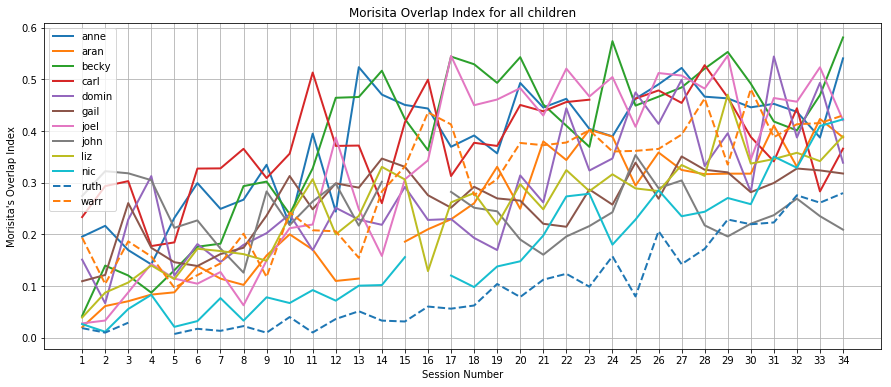

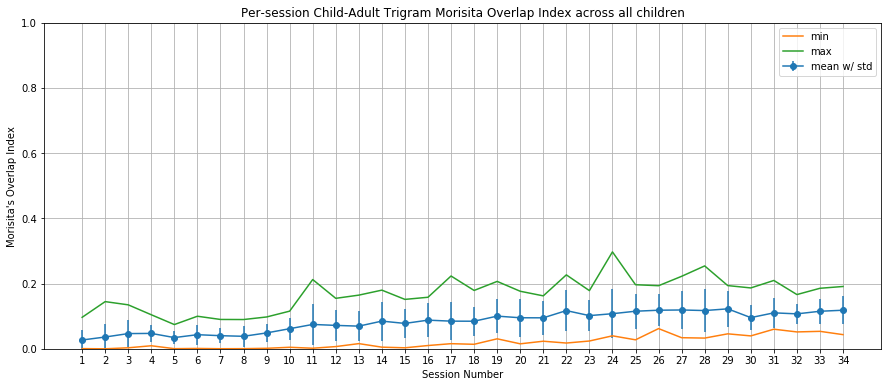

In [ ]:
plt.rcParams['figure.figsize'] = 15, 6
def plot_child(df, name, width=2, style='-', title=None, plot=True, ymax=1):
    m = df[df.corpus.eq(name)].groupby(['session']).apply(morisita_child_adult)
    m = m.align(pd.Series(index=np.arange(1, 35)))[0]
    plt.plot(stats.index, m, style, label=name, linewidth=width)
    if plot:
        per_session_plot(title or name)

def plot_all_children_together(df, name):
    children = unigrams.corpus.unique()
    from itertools import cycle, chain, repeat
    styles = cycle(chain(*(repeat(x, 10)
                     for x in '- -- -. :'.split(' '))))
    for index, child in enumerate(children):
        plot_child(df, child, 2, next(styles), plot=False)
    
    plt.legend();
    per_session_plot('Morisita Overlap Index for all children')

for dataset, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
    groups = dataset.groupby(['corpus', 'session']).apply(morisita_child_adult)
    stats = groups.groupby(level='session').describe()
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot('Per-session child-adult {} Morisita overlap index across all children'.format(name.capitalize()))
    plot_all_children_together(dataset, name)

<a id='zero-count-ngrams'></a>
# Child-Adult MOI - within-session common ngrams only

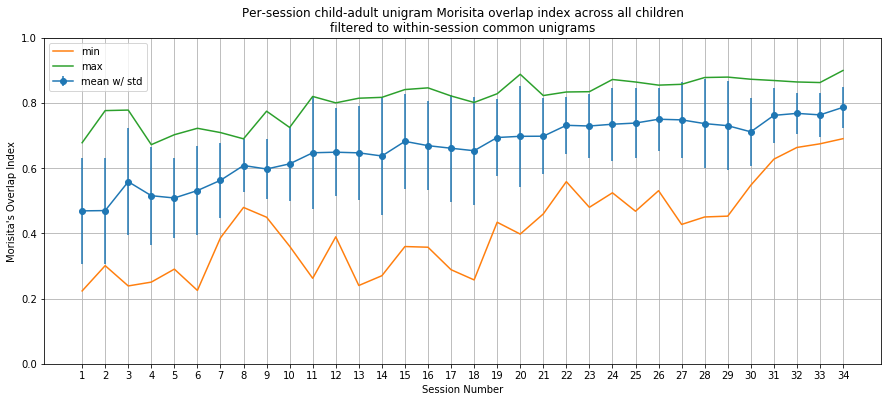

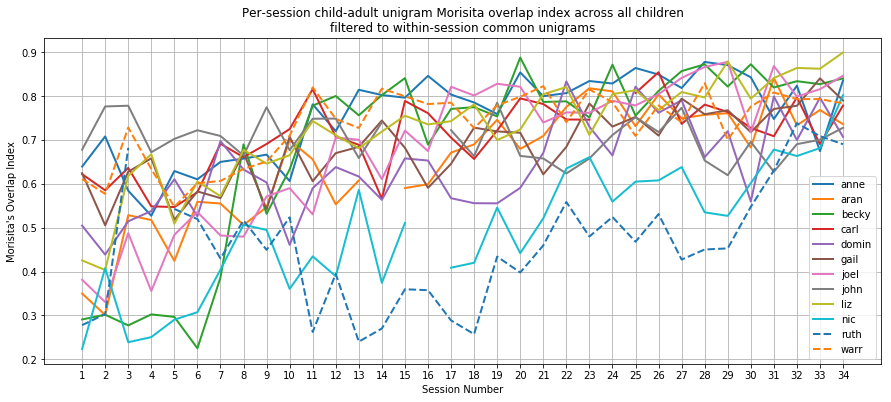

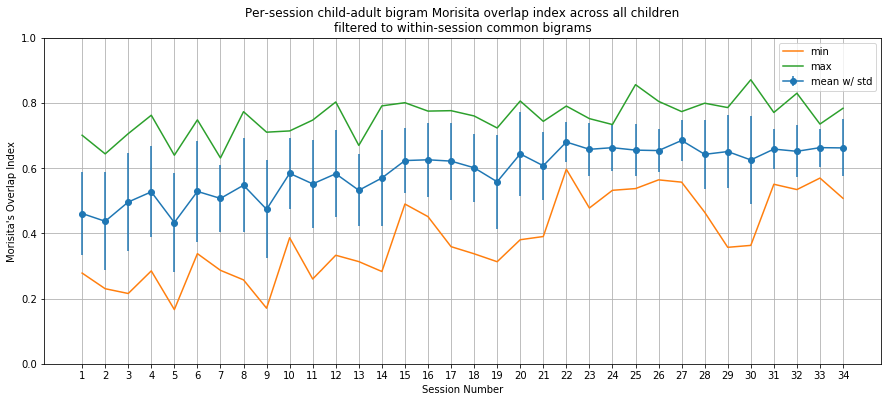

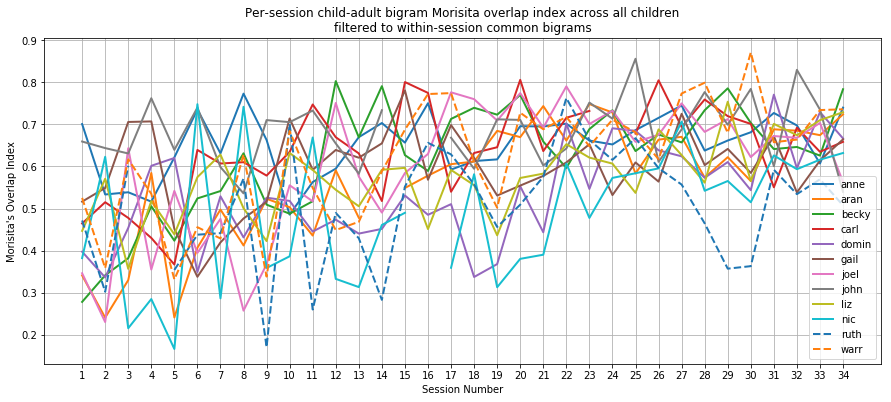

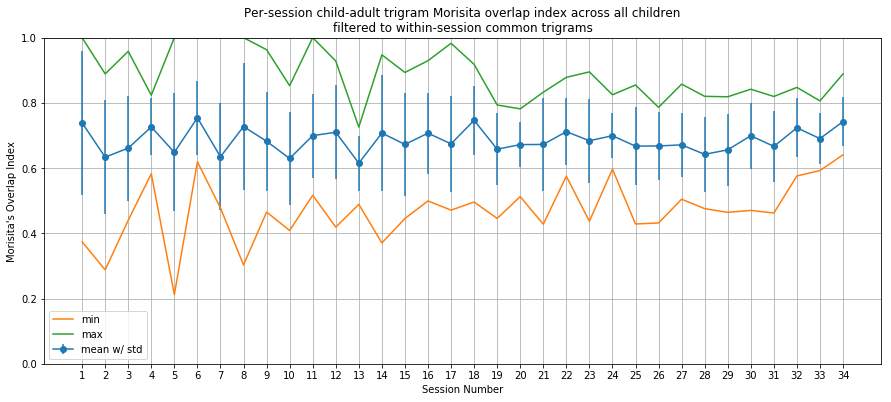

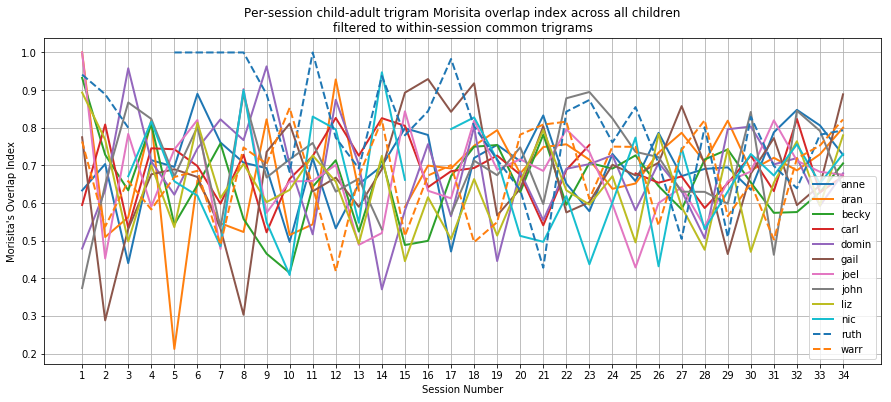

In [23]:
plt.rcParams['figure.figsize'] = 15, 6
def plot_child(df, name, width=2, style='-', title=None, plot=True, ymax=1):
    m = df[df.corpus.eq(name)].groupby(['session']).apply(morisita_child_adult, drop_zeros=True)
    m = m.align(pd.Series(index=np.arange(1, 35)))[0]
    plt.plot(stats.index, m, style, label=name, linewidth=width)
    if plot:
        per_session_plot(title or name)

def plot_all_children_together(df, name):
    children = unigrams.corpus.unique()
    from itertools import cycle, chain, repeat
    styles = cycle(chain(*(repeat(x, 10)
                     for x in '- -- -. :'.split(' '))))
    for index, child in enumerate(children):
        plot_child(df, child, 2, next(styles), plot=False)
    
    plt.legend()
    per_session_plot(('Per-session child-adult {0} Morisita overlap index across all children\n'
                      'filtered to within-session common {0}s').format(name))
    
for dataset, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
    groups = dataset.groupby(['corpus', 'session']).apply(morisita_child_adult, drop_zeros=True)
    stats = groups.groupby(level='session').describe()
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot(('Per-session child-adult {0} Morisita overlap index across all children\n'
                      'filtered to within-session common {0}s').format(name))
    plot_all_children_together(dataset, name)

<a id='adult-adult-moi'></a>
# Adult-Adult Comparisons

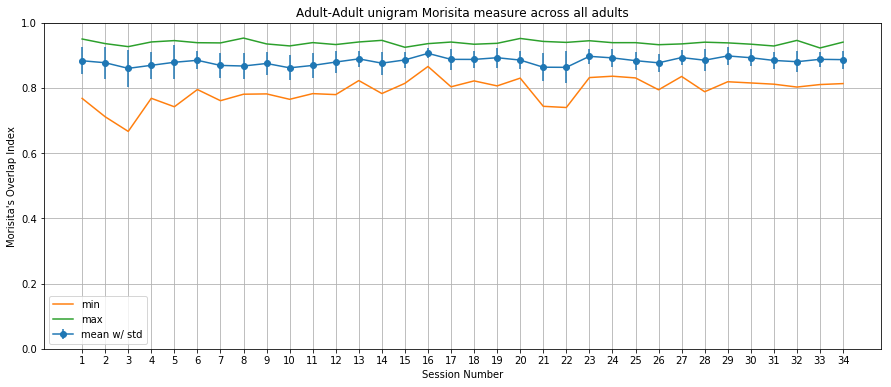

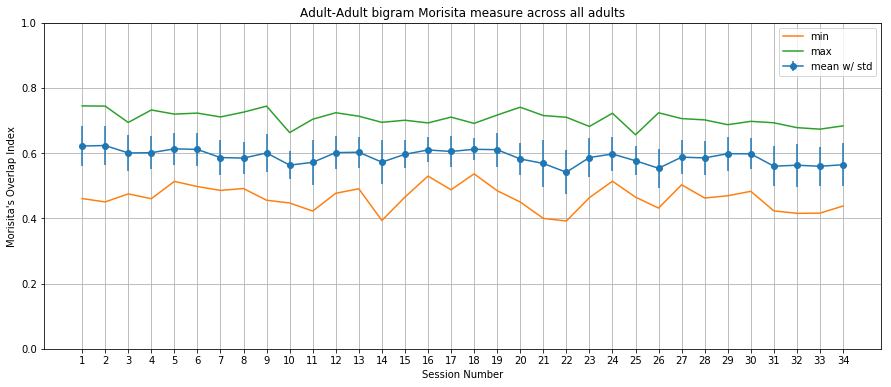

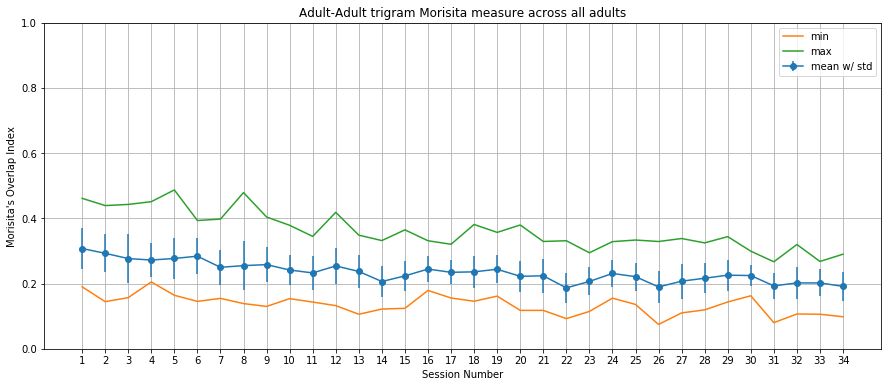

In [11]:
from itertools import combinations

def normalized_counts(series):
    counts = series.value_counts()
    return counts / counts.sum()


for dataset, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
    groups = dataset[dataset.speaker.eq('MOT')].groupby(['corpus', 'session']).groups

    adult_adult = [(session1, corpus1, corpus2, morisita(
        dataset.loc[groups[(corpus1, session1)]].ngram.pipe(normalized_counts),
        dataset.loc[groups[(corpus2, session2)]].ngram.pipe(normalized_counts)))
        for (corpus1, session1), (corpus2, session2) in combinations(groups.keys(), 2) 
        if (session1 == session2 and corpus1 != corpus2)]

    adult_adult_df = pd.DataFrame(adult_adult, columns='session corpus_a corpus_b score'.split())
    stats = (
        adult_adult_df
        .groupby('session')
        .score
        .describe()
    )
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot('Adult-Adult {} Morisita measure across all adults'.format(name))

<a id='child-child-moi'></a>
# Child-Child Comparison

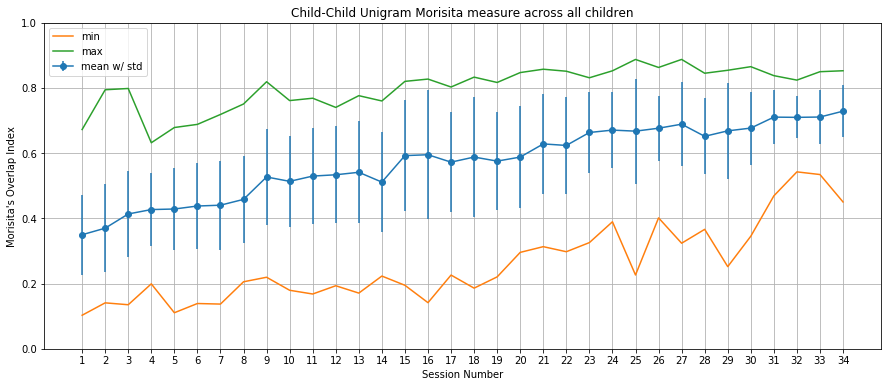

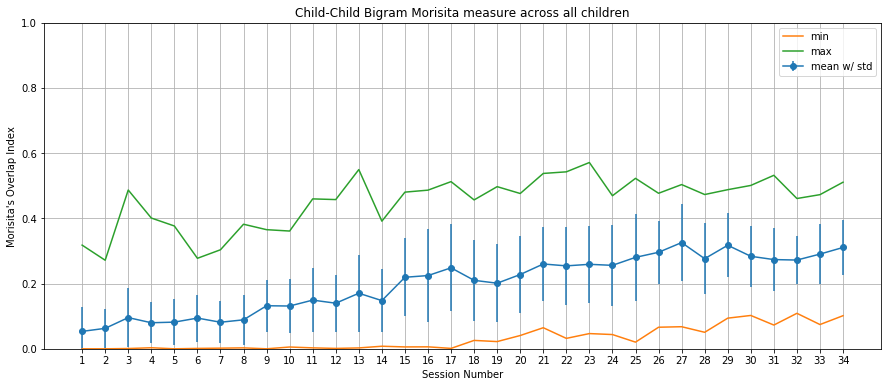

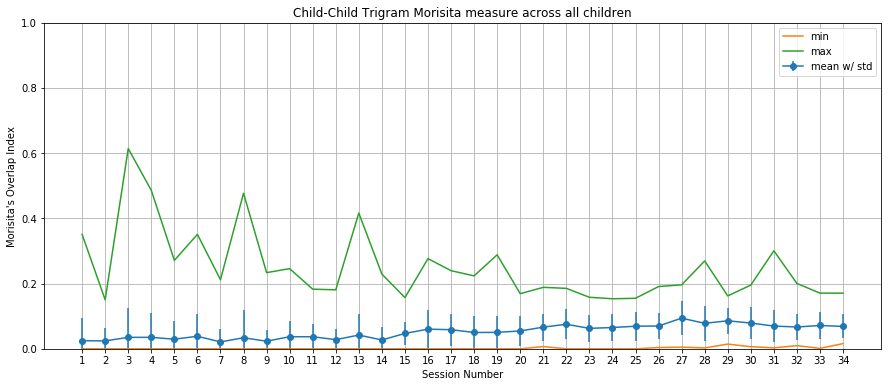

In [12]:
from itertools import combinations

def normalized_counts(series):
    counts = series.value_counts()
    return counts / counts.sum()


for dataset, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
    groups = dataset[dataset.speaker.eq('CHI')].groupby(['corpus', 'session']).groups

    adult_adult = [(session1, corpus1, corpus2, morisita(
        dataset.loc[groups[(corpus1, session1)]].ngram.pipe(normalized_counts),
        dataset.loc[groups[(corpus2, session2)]].ngram.pipe(normalized_counts)))
        for (corpus1, session1), (corpus2, session2) in combinations(groups.keys(), 2) 
        if (session1 == session2 and corpus1 != corpus2)]

    adult_adult_df = pd.DataFrame(adult_adult, columns='session corpus_a corpus_b score'.split())
    stats = (
        adult_adult_df
        .groupby('session')
        .score
        .describe()
    )
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot('Child-Child {} Morisita measure across all children'.format(name.capitalize()))

<a id='child-child-moi-common-within-session'></a>
# Child-Child Comparison dropping Zero

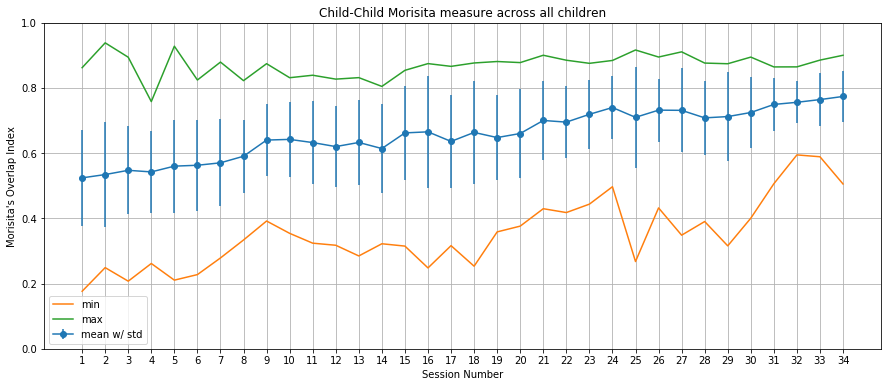

In [13]:
from itertools import combinations

def normalized_counts(series):
    counts = series.value_counts()
    return counts / counts.sum()

groups = unigrams[unigrams.speaker.eq('CHI')].groupby(['corpus', 'session']).groups

adult_adult = [(session1, corpus1, corpus2, morisita(
    unigrams.loc[groups[(corpus1, session1)]].ngram.pipe(normalized_counts),
    unigrams.loc[groups[(corpus2, session2)]].ngram.pipe(normalized_counts),
    drop_zeros=True))
    for (corpus1, session1), (corpus2, session2) in combinations(groups.keys(), 2) 
    if (session1 == session2 and corpus1 != corpus2)]

adult_adult_df = pd.DataFrame(adult_adult, columns='session corpus_a corpus_b score'.split())
stats = (
    adult_adult_df
    .groupby('session')
    .score
    .describe()
)
plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
plt.plot(stats.index, stats['min'])
plt.plot(stats.index, stats['max'])
plt.ylim(0, 1)
per_session_plot('Child-Child Morisita measure across all children'.format(name))

<a id='per-child-unigram'></a>
# Per-child plots of Morisita Unigrams

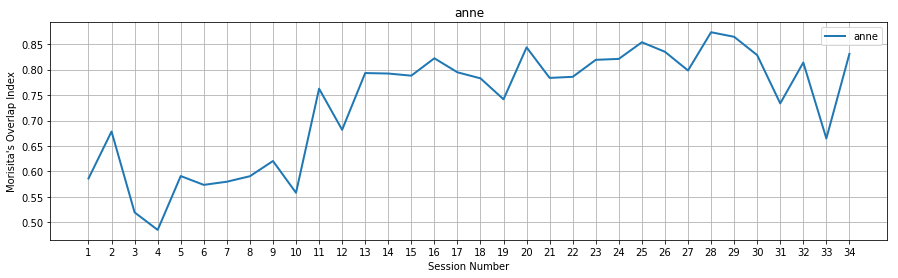

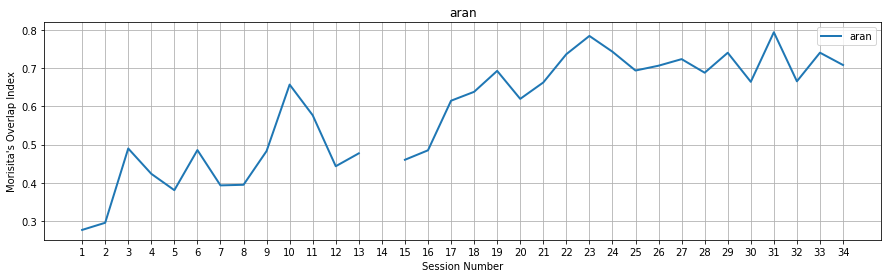

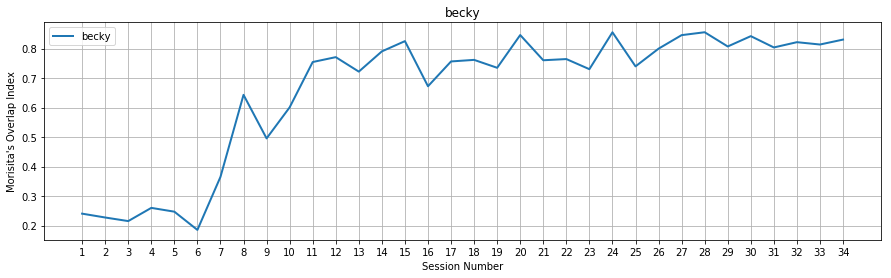

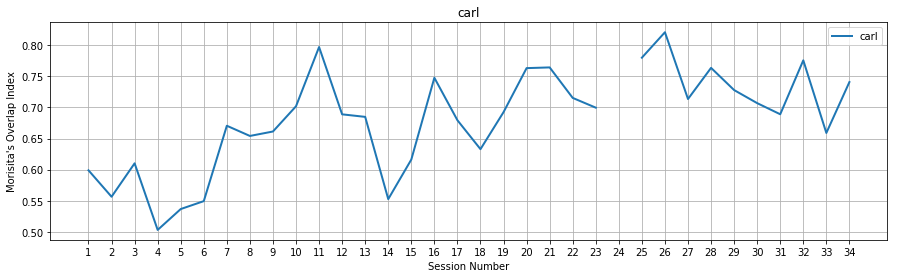

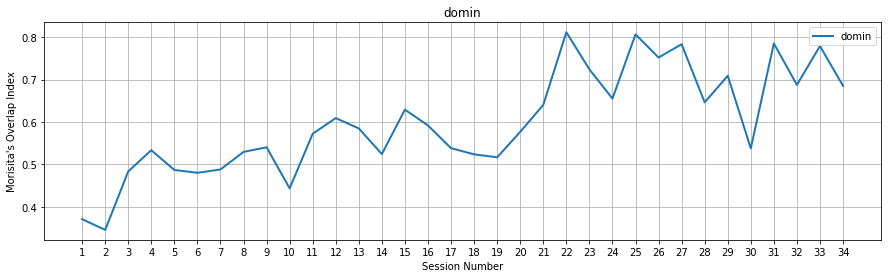

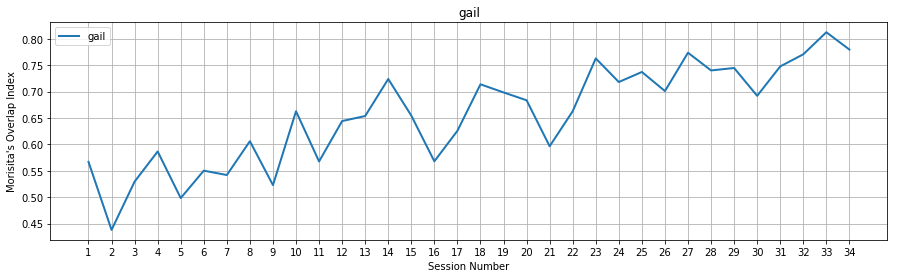

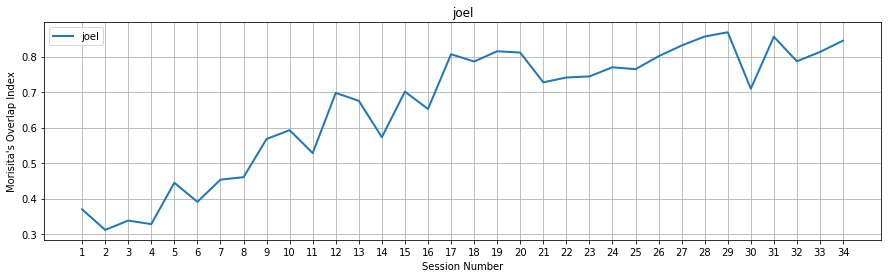

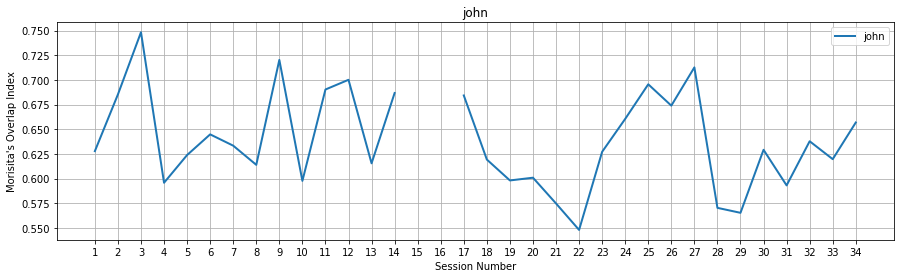

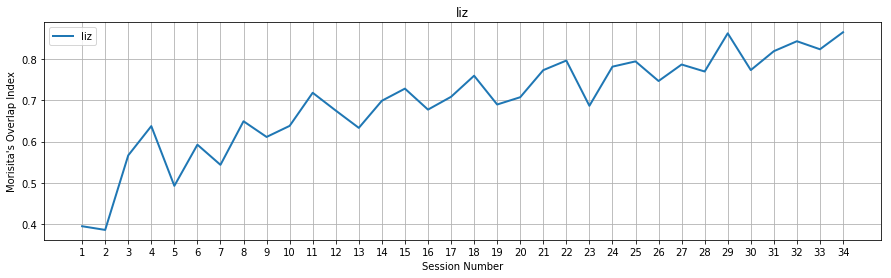

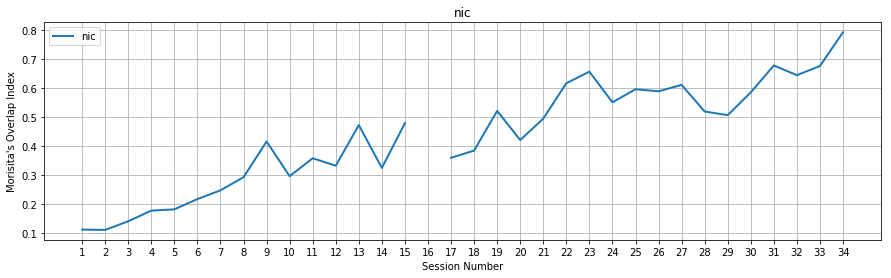

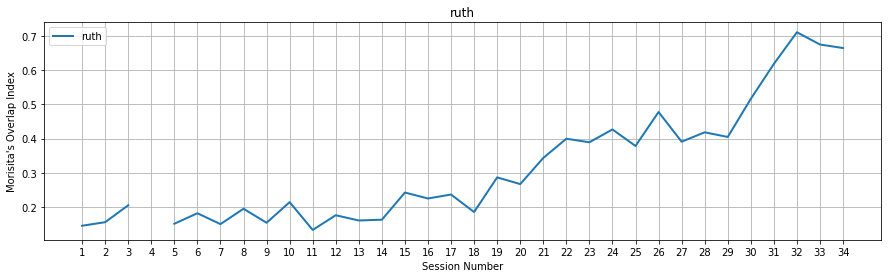

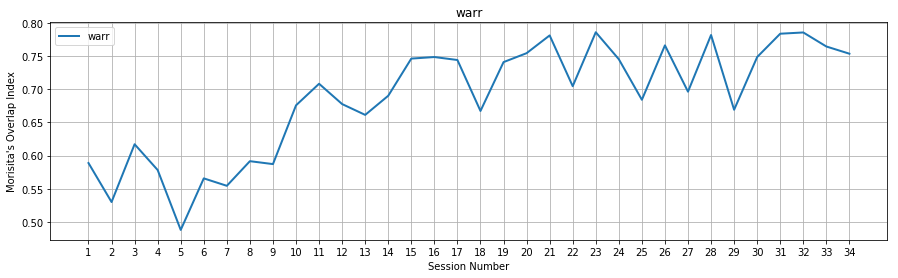

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


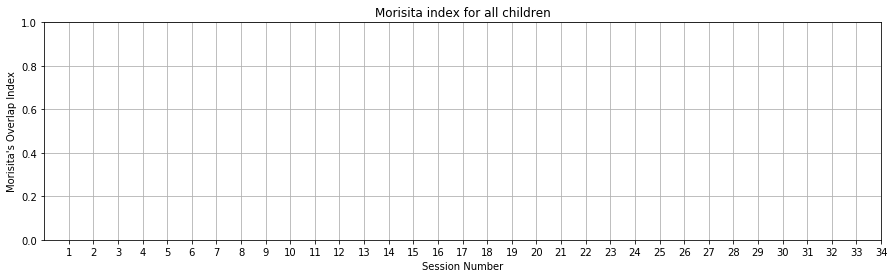

In [29]:
plt.rcParams['figure.figsize'] = 15, 4

children = unigrams.corpus.unique()

for index, child in enumerate(children):
    plot_child(unigrams, child, 2)
plt.legend();

per_session_plot('Morisita index for all children')

<a id='per-child-bigram'></a>
# Per-child plots of Morisita Bigrams

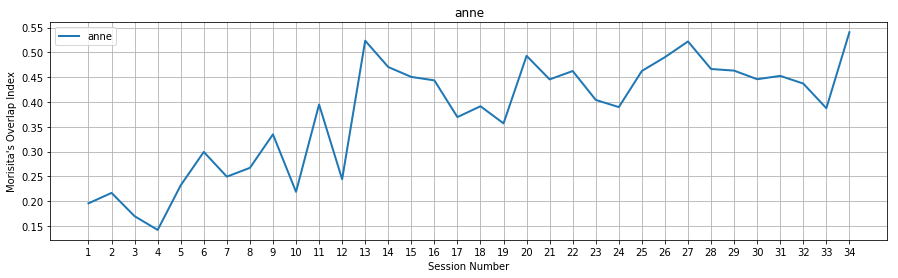

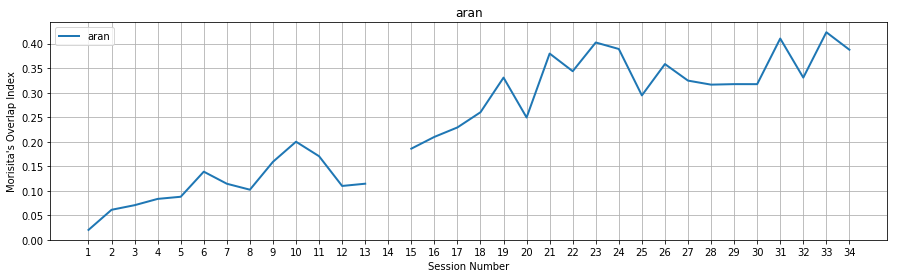

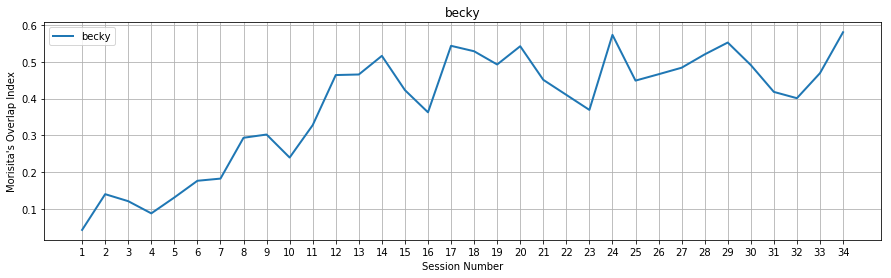

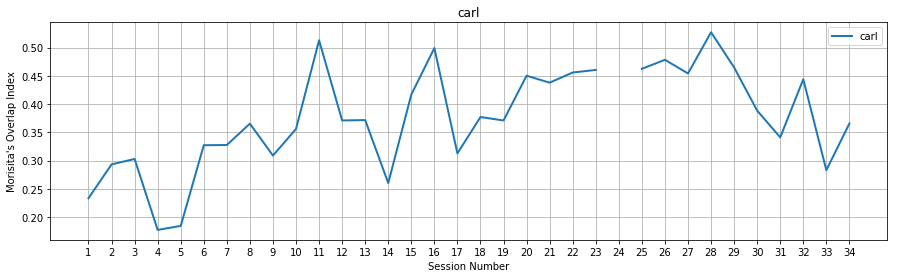

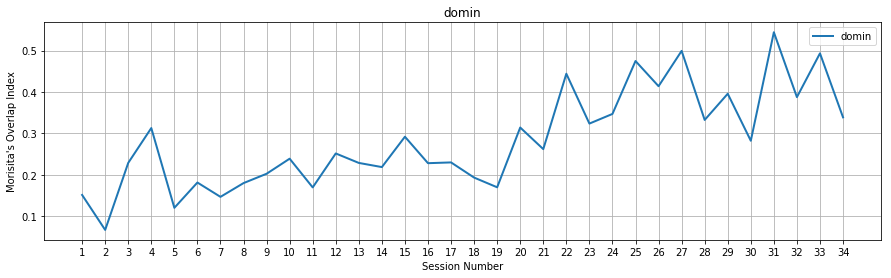

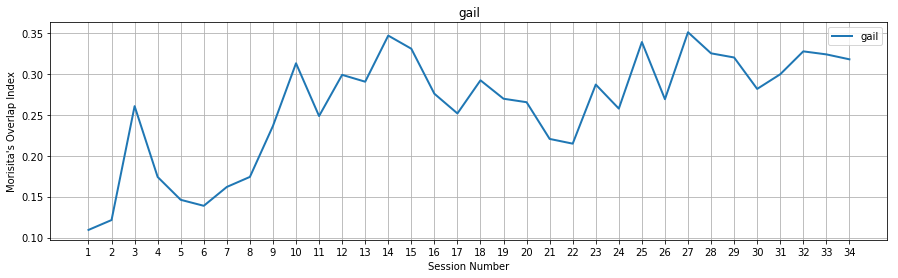

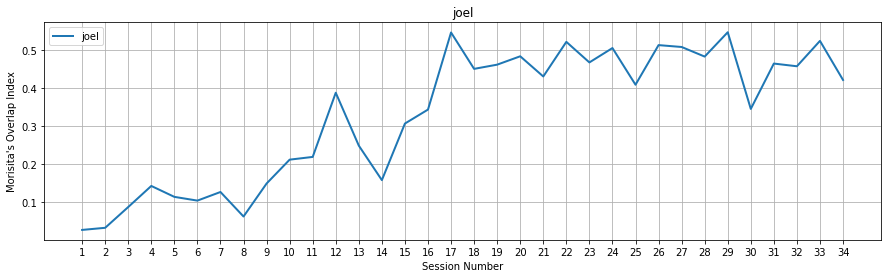

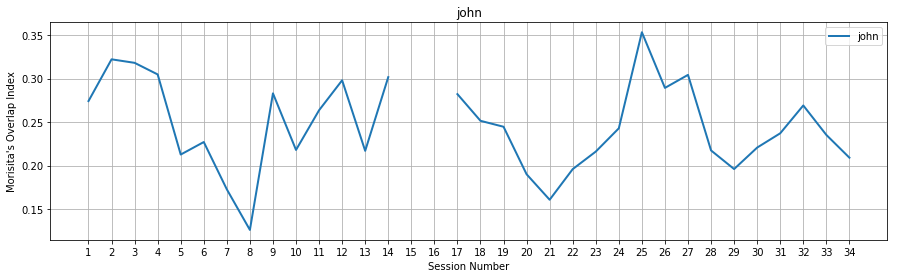

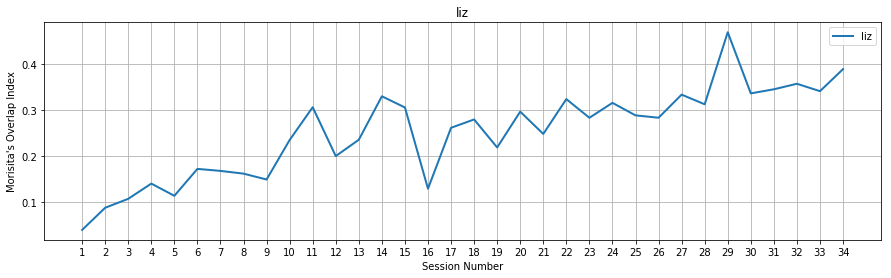

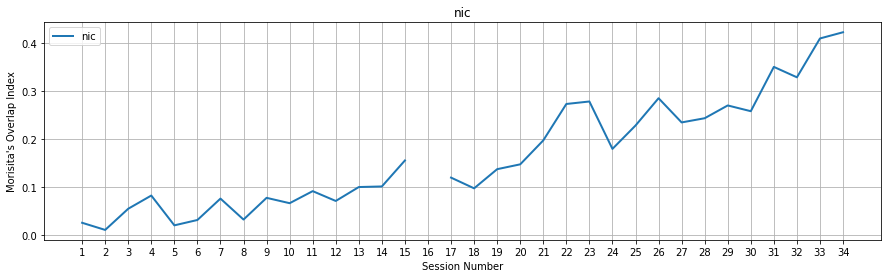

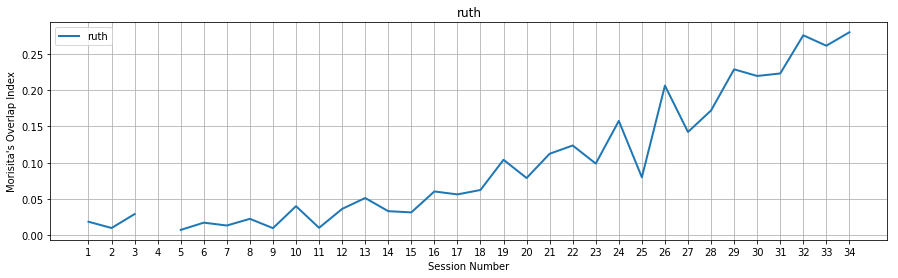

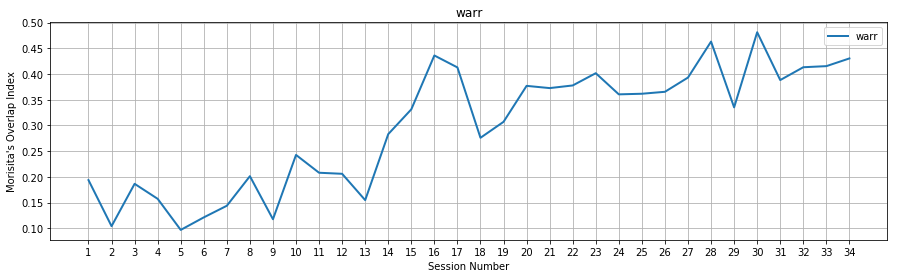

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


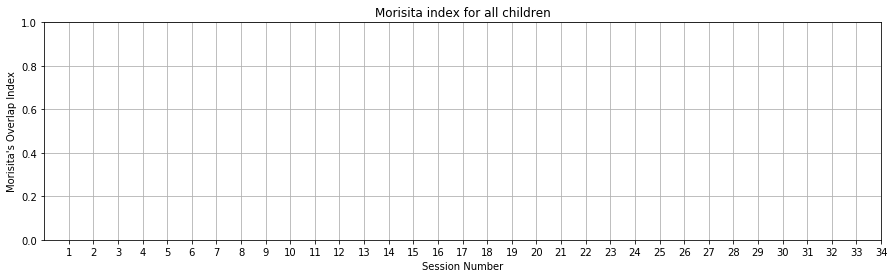

In [28]:
plt.rcParams['figure.figsize'] = 15, 4

children = unigrams.corpus.unique()

for index, child in enumerate(children):
    plot_child(bigrams, child, 2)
plt.legend();

per_session_plot('Morisita index for all children')

<a id='per-child-trigram'></a>
# Per-child plots of Morisita Trigrams

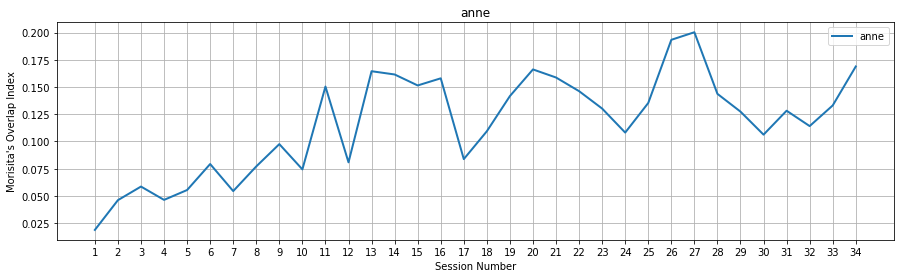

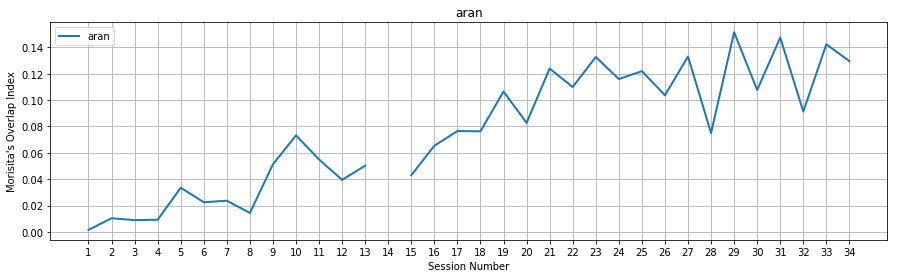

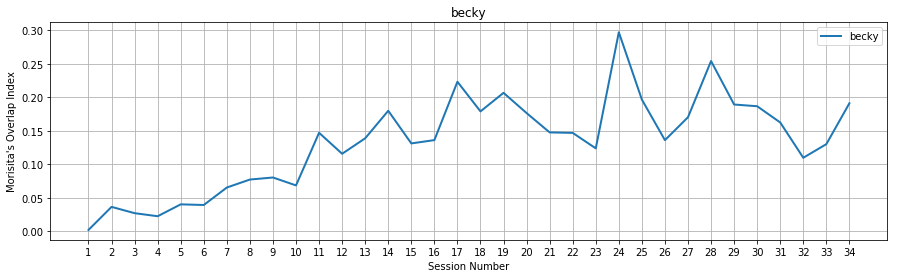

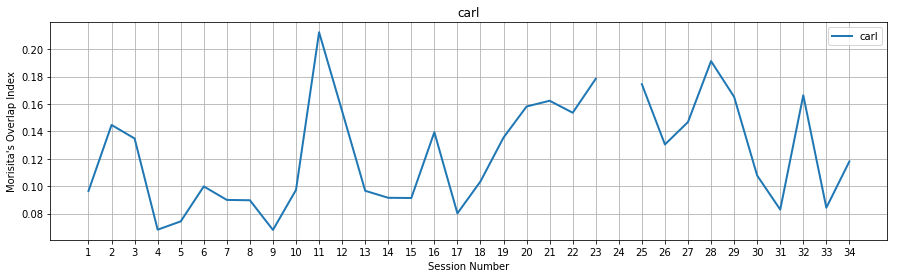

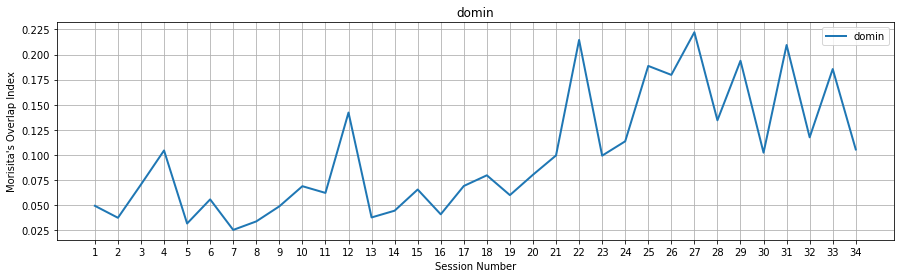

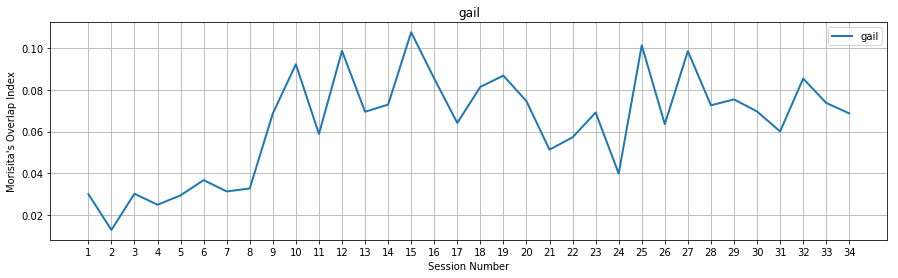

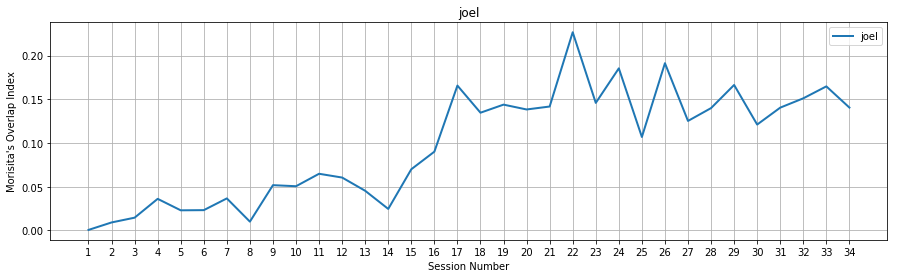

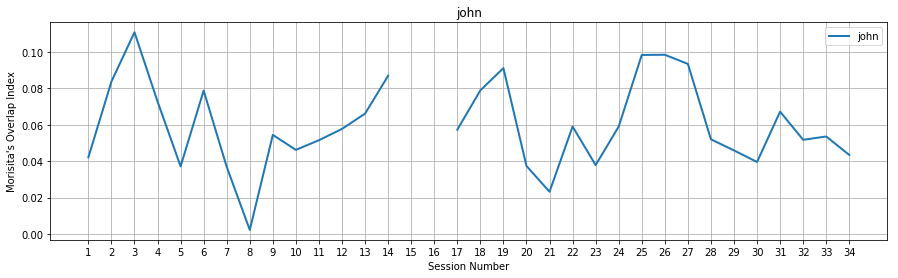

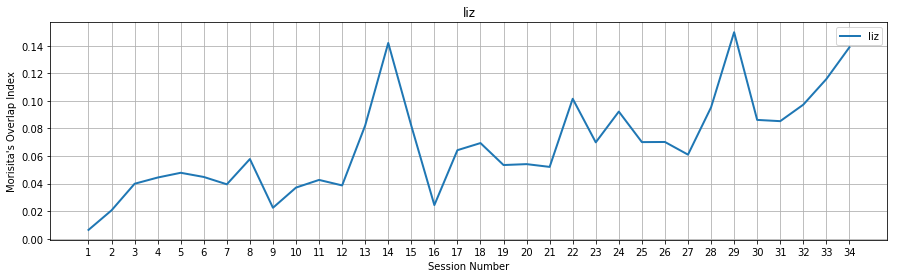

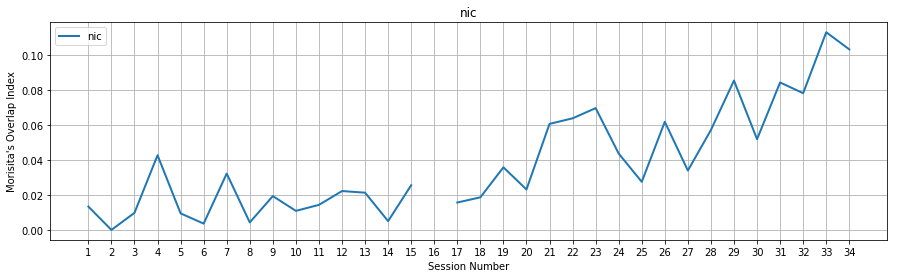

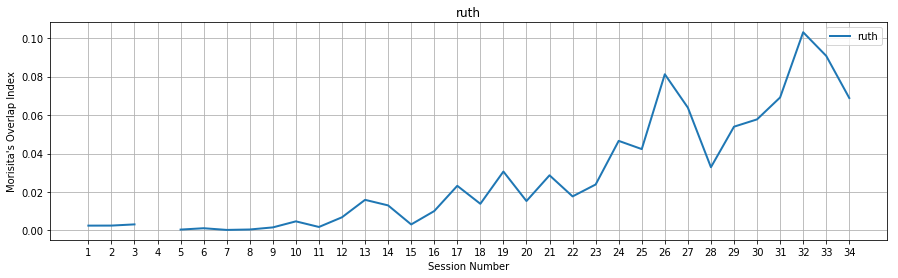

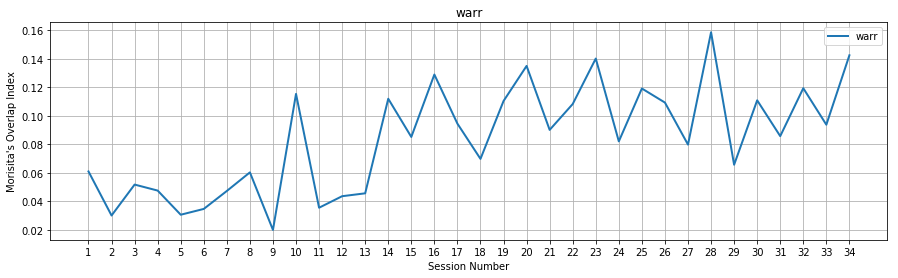

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


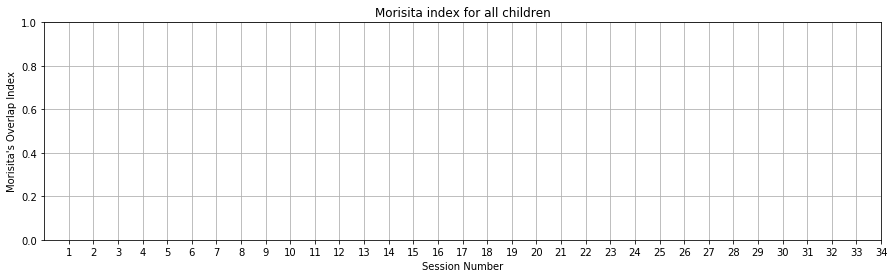

In [27]:
plt.rcParams['figure.figsize'] = 15, 4

children = unigrams.corpus.unique()

for index, child in enumerate(children):
    plot_child(trigrams, child, 2)
plt.legend();

per_session_plot('Morisita index for all children')